In [22]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

def create_grid(nx, ny, dx=1.0, dy=1.0):
    """Create a 2D grid of points."""
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

def exponential_covariance(h, variance=1.0, correlation_length=1.0):
    """Exponential covariance function."""
    return variance * np.exp(-h/correlation_length)

def gaussian_covariance(h, variance=1.0, correlation_length=1.0):
    """Gaussian covariance function."""
    return variance * np.exp(-(h/correlation_length)**2)

def matern_covariance(h, variance=1.0, correlation_length=1.0, nu=1.5):
    """Matérn covariance function."""
    from scipy.special import gamma, kv
    if nu == 0.5:
        return exponential_covariance(h, variance, correlation_length)
    
    h = np.maximum(h, 1e-10)  # Avoid zero division
    scale = correlation_length
    
    sqrt_2nu = np.sqrt(2 * nu)
    h_scale = sqrt_2nu * h / scale
    
    return variance * (2**(1-nu)) / gamma(nu) * (h_scale**nu) * kv(nu, h_scale)

def generate_grf(nx, ny, covariance_function, variance=1.0, correlation_length=1.0, 
                 dx=1.0, dy=1.0, mean=0.0, nu=1.5):
    """
    Generate a Gaussian Random Field.
    
    Parameters:
    -----------
    nx, ny : int
        Number of points in x and y directions
    covariance_function : function
        Covariance function to use
    variance : float
        Variance of the field
    correlation_length : float
        Correlation length of the field
    dx, dy : float
        Grid spacing in x and y directions
    mean : float
        Mean of the field
    nu : float
        Smoothness parameter for Matérn covariance
    
    Returns:
    --------
    numpy.ndarray
        Generated random field
    """
    # Create grid
    xx, yy = create_grid(nx, ny, dx, dy)
    points = np.column_stack((xx.flatten(), yy.flatten()))
    
    # Calculate distances between all points
    distances = spatial.distance.cdist(points, points)
    
    # Calculate covariance matrix
    if covariance_function.__name__ == 'matern_covariance':
        cov_matrix = covariance_function(distances, variance, correlation_length, nu)
    else:
        cov_matrix = covariance_function(distances, variance, correlation_length)
    
    # Ensure matrix is symmetric and positive definite
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    cov_matrix += 1e-10 * np.eye(len(cov_matrix))
    
    # Generate random field
    L = np.linalg.cholesky(cov_matrix)
    z = np.random.normal(0, 1, nx*ny)
    field = mean + np.dot(L, z)
    
    return field.reshape(ny, nx)

def generate_gaussian_random_binary_field(grf, threshold=0.0):
    """Convert Gaussian random field to binary field."""
    return (grf > threshold).astype(int)

def plot_field(field, title="Random Field", cmap='viridis'):
    """Plot the generated field."""
    plt.figure(figsize=(10, 8))
    plt.imshow(field, cmap=cmap)
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


In [46]:
# Generate fields with different covariance functions
nx, ny = 50, 50
variance = 1.0
correlation_length = 10.0

frac_1 = []
frac_2 = []
frac_3 = []

n_iter = 100

for i in range(n_iter):
    # Generate and plot continuous fields
    #f1 = generate_grf(nx, ny, exponential_covariance, variance, correlation_length)
    #f2 = generate_grf(nx, ny, gaussian_covariance, variance, correlation_length)
    f3 = generate_grf(nx, ny, matern_covariance, variance, correlation_length, nu=1.5)

    #bf1 = generate_binary_field(f1, threshold=0.1)
    #bf2 = generate_binary_field(f2, threshold=0.1)
    bf3 = generate_binary_field(f3, threshold=-1.1)

    #frac_1.append(np.sum(bf1) / (nx * ny))
    #frac_2.append(np.sum(bf2) / (nx * ny))
    frac_3.append(np.sum(bf3) / (nx * ny))



(array([ 1.,  1.,  2.,  1.,  4.,  5.,  9., 18., 30., 29.]),
 array([0.4336 , 0.49024, 0.54688, 0.60352, 0.66016, 0.7168 , 0.77344,
        0.83008, 0.88672, 0.94336, 1.     ]),
 <BarContainer object of 10 artists>)

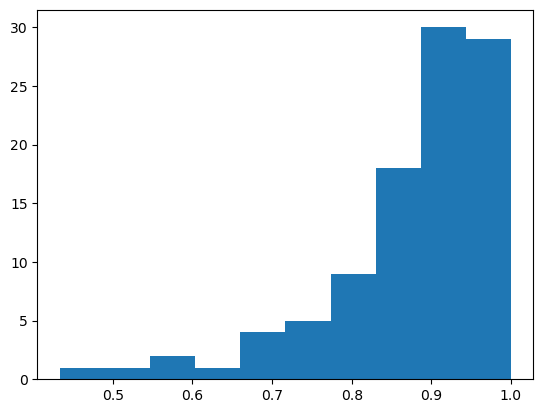

In [47]:
plt.hist(frac_3)

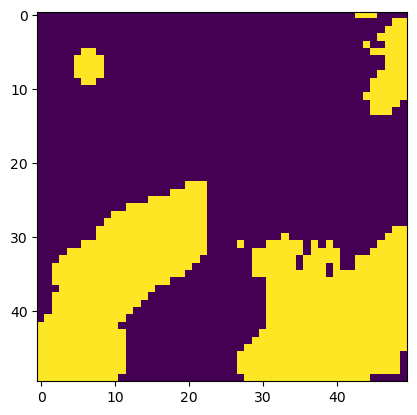

In [45]:
plt.imshow(bf3)